# Importing Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra 
import math
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
import time
from sklearn.model_selection import cross_val_score
import joblib

# data visualization(for EDA)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
sns.set(color_codes=True)
import plotly.express as px
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pakistan-super-leaguepsl-ball-by-ball-20162020/psl_formated.csv
/kaggle/input/pakistan-super-leaguepsl-ball-by-ball-20162020/PSL-2016-2022.csv


# Loading and Importing Data

In [2]:
df = pd.read_csv('../input/pakistan-super-leaguepsl-ball-by-ball-20162020/psl_formated.csv')
df.head()


,psl_year,match_number,team_1,team_2,inning,over,ball,runs,total_runs,wickets,is_four,is_six,is_wicket,wicket,wicket_text,result
0,2016,1,Islamabad United,Quetta Gladiators,1,1,1,0,0,0,False,False,False,NaN,NaN,Gladiators
1,2016,1,Islamabad United,Quetta Gladiators,1,1,2,0,0,0,False,False,False,NaN,NaN,Gladiators
2,2016,1,Islamabad United,Quetta Gladiators,1,1,3,0,0,0,False,False,False,NaN,NaN,Gladiators
3,2016,1,Islamabad United,Quetta Gladiators,1,1,4,0,0,0,False,False,False,NaN,NaN,Gladiators
4,2016,1,Islamabad United,Quetta Gladiators,1,1,5,0,0,0,False,False,False,NaN,NaN,Gladiators


# Data preprocessing (Cleaning)

In [3]:
df['wicket'].unique()

array([nan,  1.,  2.,  3.,  4.,  5.,  6.,  8.])

In [4]:
df['wicket_text'].unique()

array([nan, 'caught', 'bowled', 'lbw', 'run out', 'stumped', 'hit wicket',
       'obstruct field'], dtype=object)

In [5]:
df['wicket'].fillna(0,inplace = True)
df.head()

,psl_year,match_number,team_1,team_2,inning,over,ball,runs,total_runs,wickets,is_four,is_six,is_wicket,wicket,wicket_text,result
0,2016,1,Islamabad United,Quetta Gladiators,1,1,1,0,0,0,False,False,False,0.0,NaN,Gladiators
1,2016,1,Islamabad United,Quetta Gladiators,1,1,2,0,0,0,False,False,False,0.0,NaN,Gladiators
2,2016,1,Islamabad United,Quetta Gladiators,1,1,3,0,0,0,False,False,False,0.0,NaN,Gladiators
3,2016,1,Islamabad United,Quetta Gladiators,1,1,4,0,0,0,False,False,False,0.0,NaN,Gladiators
4,2016,1,Islamabad United,Quetta Gladiators,1,1,5,0,0,0,False,False,False,0.0,NaN,Gladiators


#### Hence, we replaced the nans in the 'wicket' column with 0.

# Boundaries Count

In [6]:
boundries_df = df.groupby(['psl_year']).agg(
    fours = ('is_four','sum'),
    sixes = ('is_six','sum'),
    matches = ('match_number','max')
    
)
boundries_df = boundries_df.reset_index()
boundries_df

,psl_year,fours,sixes,matches
0,2016,566,247,24
1,2017,552,258,24
2,2018,774,414,34
3,2019,878,374,34
4,2020,873,383,34


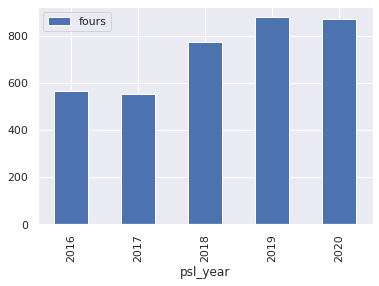

In [7]:
ax = boundries_df.plot('psl_year', 'fours', kind='bar')

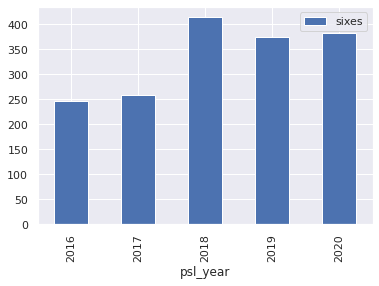

In [8]:
ax = boundries_df.plot('psl_year', 'sixes', kind='bar')

In [9]:
boundries_df['fours_per_match'] = boundries_df['fours']/boundries_df['matches']
boundries_df['six_per_match'] = boundries_df['sixes']/boundries_df['matches']

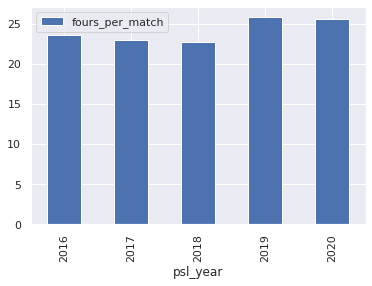

In [10]:
ax = boundries_df.plot('psl_year', 'fours_per_match', kind='bar')

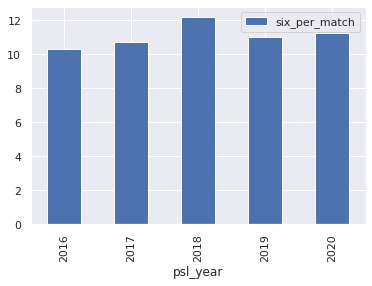

In [11]:
ax = boundries_df.plot('psl_year', 'six_per_match', kind='bar')

#### In this section we found the following insights:
- Most fours and fours per match were scored in 2019.
- Most sixes and sixes per match were scored in 2018.

# Wickets

In [12]:
wickets = df['wicket_text'].value_counts()
wicket_dict = dict(wickets)
del_keys = []
others = 0
for key, value in wicket_dict.items():
    if value <100:
        others = others+value
        del_keys.append(key)
for del_key in del_keys:
    del(wicket_dict[del_key])
wicket_dict['others']= others
wicket_dict

{'caught': 1147, 'bowled': 328, 'run out': 165, 'lbw': 130, 'others': 46}

<BarContainer object of 5 artists>

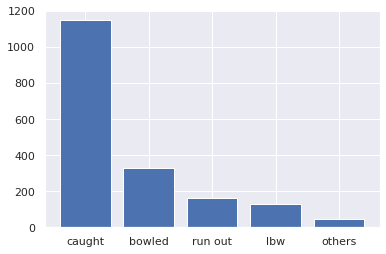

In [13]:
plt.bar(*zip(*wicket_dict.items()))

#### Here, we found an interesting fact that most of the players lost their wickets by getting caught.

# Team Based Dataframes

In [14]:
teams_df = {'Quetta' : df.loc[((df['team_1'] == "Quetta Gladiators") & (df['inning'] == 1)) | ((df['team_2'] == "Quetta Gladiators") & (df['inning'] == 2))],
'Lahore' : df.loc[((df['team_1'] == "Lahore Qalandars") & (df['inning'] == 1)) | ((df['team_2'] == "Lahore Qalandars") & (df['inning'] == 2))],
'Islamabad' : df.loc[((df['team_1'] == "Islamabad United") & (df['inning'] == 1)) | ((df['team_2'] == "Islamabad United") & (df['inning'] == 2))],
'Peshawar' : df.loc[((df['team_1'] == "Peshawar Zalmi") & (df['inning'] == 1)) | ((df['team_2'] == "Peshawar Zalmi") & (df['inning'] == 2))],
'Multan' : df.loc[((df['team_1'] == "Multan Sultans") & (df['inning'] == 1)) | ((df['team_2'] == "Multan Sultans") & (df['inning'] == 2))],
'Karachi' : df.loc[((df['team_1'] == "Karachi Kings") & (df['inning'] == 1)) | ((df['team_2'] == "Karachi Kings") & (df['inning'] == 2))]
}

# Team Based Runs

In [15]:
team_runs = {}
for team_name, value in teams_df.items():
    team_runs[team_name] = value['runs'].sum()
team_matches = {}
for team_name , value in teams_df.items():
    team_matches[team_name] = value.groupby(['psl_year', 'match_number']).ngroups

<BarContainer object of 6 artists>

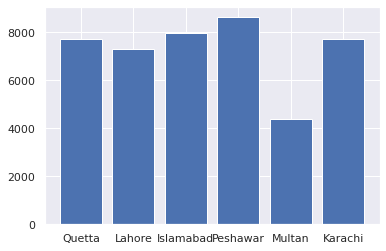

In [16]:
plt.bar(*zip(*team_runs.items()))

#### Among all the teams Peshawar scored the most runs, followed by Islamabad United.

# Team Based Percentage Runs in Boundaries

In [17]:
team_boundry_runs = {}
for team_name, value in teams_df.items():
    sixes = value['is_six'].sum()
    fours = value['is_four'].sum()
    team_boundry_runs[team_name]= (sixes*6)+(fours*4)

boundry_run_percentage = {}
for team, runs in team_runs.items():
#     print (f"{team} scored {(team_boundry_runs[team]/runs)*100}% runs in boundries")
    boundry_run_percentage[team] = (team_boundry_runs[team]/runs)*100

<BarContainer object of 6 artists>

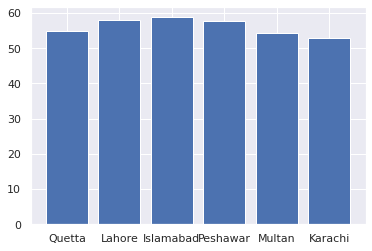

In [18]:
plt.bar(*zip(*boundry_run_percentage.items()))

#### This bar chart shows that Islamabad United dealt more in boundaries to score the runs.

# Dot Balls Played

In [19]:
dot_balls_played = {}
total_balls_played = {}
for team, value in teams_df.items():
    dot_balls_played[team]=value[value['runs']==0].shape[0]
    total_balls_played[team]= value.shape[0]

dot_ball_percentage ={}
for team , value in dot_balls_played.items():
    dot_ball_percentage[team] = (value/total_balls_played[team])*100

# for team , value in dot_ball_percentage.items():
#     print (f"Team : {team} played {math.trunc(value)}% of dot balls")

<BarContainer object of 6 artists>

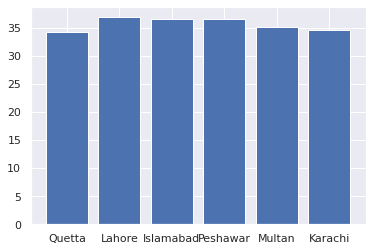

In [20]:
plt.bar(*zip(*dot_ball_percentage.items()))

#### Here, it shows that Lahore Qalanders played the most Dot balls.

# Six Hit Per Team

<BarContainer object of 6 artists>

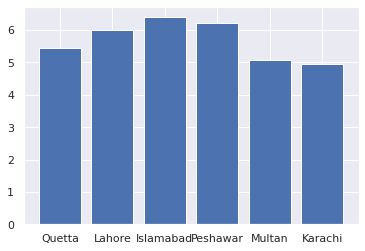

In [21]:
six_per_team = {}
for team, value in teams_df.items():
    six_per_team[team] = value['is_six'].sum()

six_per_match ={}
for team ,value in six_per_team.items():
    six_per_match[team] = value/team_matches[team]

plt.bar(*zip(*six_per_match.items()))

#### Talking about sixes hit by the teams, Islamabad United placed the most sixes per match.

<BarContainer object of 6 artists>

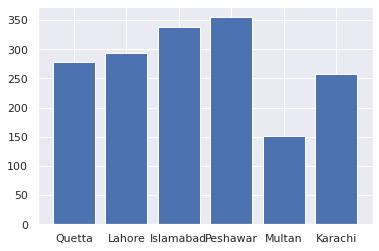

In [22]:
plt.bar(*zip(*six_per_team.items()))

#### Talking about sixes hit by the teams, Peshawar Zalmi placed the most sixes per team.

# Four Hit Per Team

<BarContainer object of 6 artists>

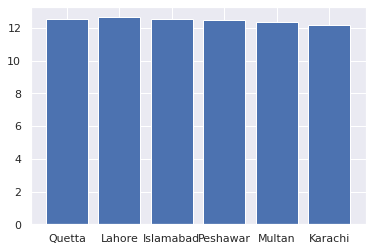

In [23]:
four_per_team = {}
for team, value in teams_df.items():
    four_per_team[team] = value['is_four'].sum()

four_per_match ={}
for team ,value in four_per_team.items():
    four_per_match[team] = value/team_matches[team]

plt.bar(*zip(*four_per_match.items()))

#### It seems a coincidence that all the teams scored almost similar number of fours per match.

# Runs Scored Per Team

<BarContainer object of 6 artists>

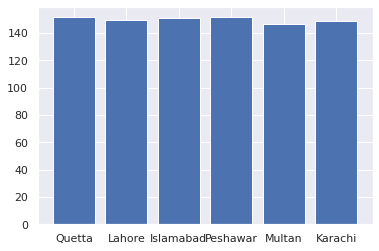

In [24]:
runs_per_team = {}
for team, value in teams_df.items():
    runs_per_team[team] = value['runs'].sum()

runs_per_match ={}
for team ,value in runs_per_team.items():
    runs_per_match[team] = value/team_matches[team]

plt.bar(*zip(*runs_per_match.items()))

#### Here, again it seems that all the teams scored almost similar number of runs per match.

# Wickets Per Team

<BarContainer object of 6 artists>

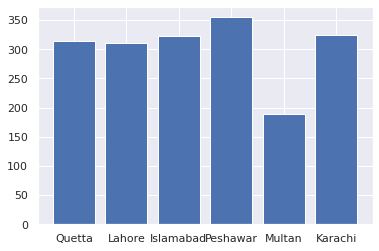

In [25]:
wickets_per_team = {}
for team, value in teams_df.items():
    wickets_per_team[team] = value['is_wicket'].sum()

wickets_per_match ={}
for team ,value in wickets_per_team.items():
    wickets_per_match[team] = value/team_matches[team]

plt.bar(*zip(*wickets_per_team.items()))

#### The above barchart shows that, Peshawar Zalmi had the most wickets being fallen per team.

<BarContainer object of 6 artists>

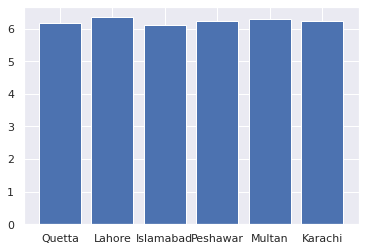

In [26]:
plt.bar(*zip(*wickets_per_match.items()))

#### Her the above barchart shows that, Lahore Qalanders had the most wickets being fallen per match.

# Defining Functions to bulit Prediction Model

In [27]:
# Method to calculate if the team batting second won or not
def is_winner(row):
    if type(row['result']) == str:
        if row['result'] in row['team_2']:
            return 1
        return 0
    else:
        return 0

In [28]:
# Method to calculate if a player was dismissed on this ball or not
def is_out(row):
    if type(row['player_dismissed']) == str:
        return 1
    else:
        return 0

# Data Manipulation to Extract Important Features

In [29]:
# Splitting on Innings
first_inning = df[df['inning']==1]
second_inning = df[df['inning']==2]

In [30]:
# Calculating Target
total_sum = first_inning.groupby(["psl_year","match_number"]).agg(
   target= ("runs","sum")
)

In [31]:
total_sum = total_sum.reset_index()

In [32]:
# Merging the DF
new_df = pd.merge(total_sum, second_inning,  how='left', left_on=['psl_year','match_number'], right_on = ['psl_year','match_number'])

In [33]:
# Calculating if Second Inning team won or not 
new_df['won'] = new_df.apply(is_winner, axis=1)

In [34]:
# Calculating balls left
new_df['balls_left'] = 120-(((new_df['over']-1)*6)+new_df['ball'])

In [35]:
# Creating the Final Dataset
final_df = new_df[['over','ball','total_runs','wickets','target','balls_left','won']]

In [36]:
final_df.head()

,over,ball,total_runs,wickets,target,balls_left,won
0,1.0,1.0,0.0,0.0,128,119.0,1
1,1.0,2.0,0.0,0.0,128,118.0,1
2,1.0,3.0,0.0,0.0,128,117.0,1
3,1.0,4.0,2.0,0.0,128,116.0,1
4,1.0,5.0,2.0,0.0,128,115.0,1


In [37]:
final_df['runs_left'] = final_df['target']- final_df['total_runs']

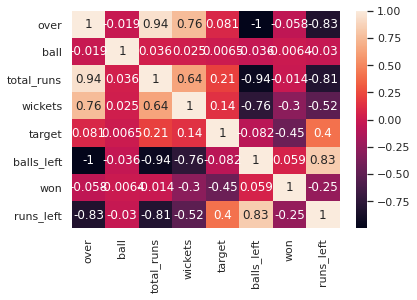

In [38]:
corrMatrix = final_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

# Selecting particular columns for our model

In [39]:
new_cols =['wickets','balls_left','runs_left','won']

In [40]:
psl_df = final_df[new_cols]
psl_df.head()

,wickets,balls_left,runs_left,won
0,0.0,119.0,128.0,1
1,0.0,118.0,128.0,1
2,0.0,117.0,128.0,1
3,0.0,116.0,126.0,1
4,0.0,115.0,126.0,1


In [41]:
psl_df.isnull().sum()

wickets       2
balls_left    2
runs_left     2
won           0
dtype: int64

In [42]:
psl_df.shape

(16318, 4)

In [43]:
psl_df = psl_df.apply (pd.to_numeric, errors='coerce')
psl_df = psl_df.dropna()

In [44]:
psl_df.shape

(16316, 4)

In [45]:
# X and Y Split
y = psl_df.iloc[:,3]
X = psl_df.iloc[:,:3]

In [46]:
# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

# Making predictions with Random Forest Classifier

In [47]:
# Training Model
start = time.time()
RF = RandomForestClassifier(n_estimators = 10000, max_depth=6, random_state=0)
RF.fit(X_train, y_train)
print(f"Time Taken to Train {time.time()-start} seconds")

Time Taken to Train 73.3881311416626 seconds


In [48]:
y_pred_test = RF.predict(X_test)

In [49]:
accuracy_score(y_test, y_pred_test)

0.7837009803921569

In [50]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.60      0.68      1229
           1       0.79      0.89      0.84      2035

    accuracy                           0.78      3264
   macro avg       0.78      0.75      0.76      3264
weighted avg       0.78      0.78      0.78      3264



In [51]:
current= {
    "wickets":1,
    "balls_left" :105,
    "runs_left":137
}
current_df = pd.DataFrame(current,index=[0])
RF.predict_proba(current_df)

array([[0.3422821, 0.6577179]])

# Making predictions with XGBoost Classifier

In [52]:
XGBC = xgboost.XGBClassifier()
XGBC.fit(X_train, y_train)

[09:26:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
y_pred = XGBC.predict(X_test)
predictions = [round(value) for value in y_pred]

In [54]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.31%


In [55]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73      1229
           1       0.82      0.90      0.86      2035

    accuracy                           0.81      3264
   macro avg       0.81      0.78      0.79      3264
weighted avg       0.81      0.81      0.81      3264



In [56]:
current= {
    "wickets":1,
    "balls_left" :105,
    "runs_left":137
}
current_df = pd.DataFrame(current,index=[0])
XGBC.predict_proba(current_df)

array([[0.22686851, 0.7731315 ]], dtype=float32)

# Making predictions with SVM 

In [57]:
# Define model
SVC_model = svm.SVC()

# Fit model
SVC_model.fit(X_train, y_train)

#Predict Output 
predicted = SVC_model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using SVC Classifier is:',format(a*100))

The accuracy using SVC Classifier is: 78.09436274509804


In [58]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.77      0.60      0.67      1229
           1       0.79      0.89      0.84      2035

    accuracy                           0.78      3264
   macro avg       0.78      0.74      0.75      3264
weighted avg       0.78      0.78      0.77      3264



# Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression()

# Fit the model to the training data
LR_model.fit(X_train, y_train)

#Predict Output 
predicted = LR_model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using Logistic Regression is:',format(a*100))

The accuracy using Logistic Regression is: 77.32843137254902


# Naive Bayes

In [63]:
from sklearn.naive_bayes import GaussianNB
NB_model = GaussianNB()

# Fit the model to the training data
NB_model.fit(X_train, y_train)

#Predict Output 
predicted = NB_model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using Naive Bayes is:',format(a*100))

The accuracy using Naive Bayes is: 72.45710784313727


# LGBM Classifier

In [117]:
import lightgbm as lgb
# Create an instance of the LGBMClassifier model
LGB_model = lgb.LGBMClassifier(
    boosting_type='gbdt',       # The type of boosting algorithm to use ('gbdt': Gradient Boosting Decision Tree)
    num_leaves=60,              # Number of leaves in one tree (default: 31)
    max_depth=-1,               # Maximum tree depth for base learners (-1 means no limit, default: -1)
    learning_rate=0.2,          # Learning rate or shrinkage rate to prevent overfitting (default: 0.1)
    n_estimators=120            # Number of boosting iterations (default: 100)
)

# Fit the model on the training data
LGB_model.fit(X_train, y_train)

#Predict Output 
predicted = LGB_model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using LGBM Classifier is:',format(a*100))

The accuracy using LGBM Classifier is: 81.31127450980392


In [105]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.79      0.69      0.74      1229
           1       0.83      0.89      0.86      2035

    accuracy                           0.81      3264
   macro avg       0.81      0.79      0.80      3264
weighted avg       0.81      0.81      0.81      3264



So we will use LGBM as our model as it is slightly better than XGBoost

In [119]:
# Saving Model
joblib.dump(LGB_model, "./model.joblib")

['./model.joblib']